# This notebook is to attempt to predict the fuel price for t+1

In [106]:
import pandas.util.testing as tm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

sns.set()

random_state = 123_456
np.random.seed(random_state)

### TODO
* Add more features (e.g. volatility)
* Predict/forecast using 120 day regimes as proposed in the paper
* Predict for next month, week, 3 days, and then combine
* Visualize other fuel types with P98
* Visualize specific service stations P98 with NSW P98
* Move the oil price back 2 weeks [done]
* Investigate AU current account imports/exports and this has any effects on the fuel price
* For forecast/prediction, use last quater, last 6 months, last year, last 18 months
* Do up/down classification. This turned out to be worthless [done]
* See if it helps to lag oil prices or wholesale Tapis/MOGAS fuel prices by 2 weeks. Changes in Singapore 
  prices can take around two weeks to work their way through the supply chain in Australian cities [done]
* See if it helps to also use current fuel price lagged by a. one month, and/or b. one year
* Volumes of fuel sold could affect the price. E.g. should lower than expected volumes have been sold, the price
  might be lowered so as to make space for the fuel that has already been ordered and on its way. E.g. this could
  be caused by rainy weather over public holidays when a higher than normal volume of fuel would have been 
  sold, would the weather have been sunny 

In [107]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

## Add date features

In [108]:
# df['day'] = df.index.day.astype('category')
# df['week'] = df.index.week.astype('category')
# df['weekday'] = df.index.weekday.astype('category')

# df['day'] = df.index.day
# df['week'] = df.index.week
# df['weekday'] = df.index.weekday

## Add t+1

In [109]:
# df['price_next_day'] = df.price.shift(-1)
# df.price_next_day.fillna(method='ffill', inplace=True)
# df.price_next_day = df.price_next_day.astype(np.int32)

In [110]:
df

price  tapis_oil_price_t_minus_10  national_avg_price  \
2017-01-01   1417                        5863                1184   
2017-01-02   1436                        5863                1184   
2017-01-03   1409                        5863                1184   
2017-01-04   1542                        5863                1186   
2017-01-05   1582                        5863                1191   
...           ...                         ...                 ...   
2019-12-27   1608                        7084                1336   
2019-12-28   1589                        7103                1349   
2019-12-29   1579                        7159                1349   
2019-12-30   1602                        7198                1349   
2019-12-31   1609                        7177                1357   

            sgd_exchange_rate_t_minus_6  usd_exchange_rate  volume_in_ml  \
2017-01-01                       1.0425             0.7186          18.7   
2017-01-02                       1.0425             0.7186          18.7   
2017-01-03                       1.0425             0.7226          18.7   
2017-01-04                       1.0425             0.7284          18.7   
2017-01-05                       1.0425             0.7337          18.7   
...                                 ...                ...           ...   
2019-12-27                       0.9386             0.6978          14.3   
2019-12-28                       0.9386             0.6995          14.3   
2019-12-29                       0.9386             0.6995          14.3   
2019-12-30                       0.9382             0.6995          14.3   
2019-12-31                       0.9377             0.7022          14.3   

            wholesale_price_t_minus_4  wholesale_cluster_label  \
2017-01-01                       1183                        1   
2017-01-02                       1183                        1   
2017-01-03                       1183                        0   
2017-01-04                       1183                        0   
2017-01-05                       1183                        0   
...                               ...                      ...   
2019-12-27                       1332                        0   
2019-12-28                       1332                        0   
2019-12-29                       1335                        0   
2019-12-30                       1336                        0   
2019-12-31                       1338                        0   

            tapis_oil_cluster_label  price_t_plus_1  
2017-01-01                        1            1436  
2017-01-02                        1            1409  
2017-01-03                        1            1542  
2017-01-04                        1            1582  
2017-01-05                        1            1529  
...                             ...             ...  
2019-12-27                        0            1589  
2019-12-28                        0            1579  
2019-12-29                        0            1602  
2019-12-30                        0            1609  
2019-12-31                        0            1609  

[1095 rows x 10 columns]

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 10 columns):
price                          1095 non-null int32
tapis_oil_price_t_minus_10     1095 non-null int64
national_avg_price             1095 non-null int32
sgd_exchange_rate_t_minus_6    1095 non-null float64
usd_exchange_rate              1095 non-null float64
volume_in_ml                   1095 non-null float64
wholesale_price_t_minus_4      1095 non-null int64
wholesale_cluster_label        1095 non-null int64
tapis_oil_cluster_label        1095 non-null int64
price_t_plus_1                 1095 non-null int64
dtypes: float64(3), int32(2), int64(5)
memory usage: 85.5 KB


In [112]:
non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4','sgd_exchange_rate_t_minus_6']
# non_categorical_features = ['tapis_oil_price_t_minus_10','wholesale_price_t_minus_4']
# non_categorical_features = ['price','tapis_oil_price','national_avg_price','usd_exchange_rate','volume_in_ml',
#                             'day','week','weekday']

## EDA

In [113]:
# plot selected corr's
# plot_for_columns = ['day','week']

# for col in plot_for_columns:
#     _ = sns.lmplot(x='price_next_day', y=col, data=df)
#     _ = plt.ylabel(col)
#     _ = plt.xlabel("Next day fuel price x 10")
#     _ = plt.legend(labels=(), title='r = {}'.format(round(df.price.corr(df[col]), 4)))
# plt.show()

In [114]:
# _ = sns.pairplot(df)

In [115]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

### Plot Histogram Fuel Price


 mu = 1566.75 and sigma = 123.28



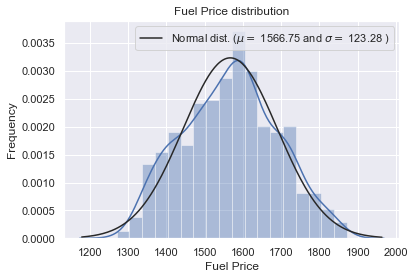

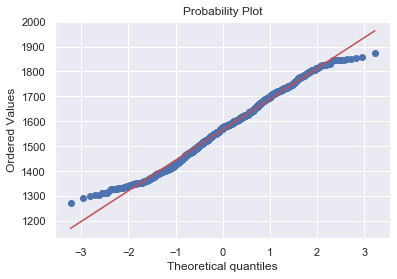

Skewness: 0.043166
Kurtosis: -0.605470


In [116]:
sns.distplot(df.price, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.price)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Fuel Price')
plt.title('Fuel Price distribution')

fig = plt.figure()
res = stats.probplot(df.price, plot=plt)
plt.show()

print("Skewness: %f" % df.price.skew())
print("Kurtosis: %f" % df.price.kurt())

In [117]:
sns.distplot(df.wholesale_price_t_minus_4, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.wholesale_price_t_minus_4)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Wholesale t-4 Fuel Price')
plt.title('Wholesale t-4 Avg Fuel Price distribution')

fig = plt.figure()
res = stats.probplot(df.wholesale_price_t_minus_4, plot=plt)
plt.show()

print("Skewness: %f" % df.wholesale_price_t_minus_4.skew())
print("Kurtosis: %f" % df.wholesale_price_t_minus_4.kurt())


 mu = 1253.19 and sigma = 92.81



Skewness: 0.071939
Kurtosis: -0.997683


###  Plot Histogram Tapis Oil Price

In [118]:
sns.distplot(df.tapis_oil_price_t_minus_10, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.tapis_oil_price_t_minus_10)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.xlabel('Tapis Oil t-10 Price')
plt.title('Tapis t-10 Oil Price distribution')

fig = plt.figure()
res = stats.probplot(df.tapis_oil_price_t_minus_10, plot=plt)
plt.show()

print("Skewness: %f" % df.tapis_oil_price_t_minus_10.skew())
print("Kurtosis: %f" % df.tapis_oil_price_t_minus_10.kurt())


 mu = 6576.46 and sigma = 919.80



Skewness: -0.083345
Kurtosis: -0.631187



 mu = 1.01 and sigma = 0.05



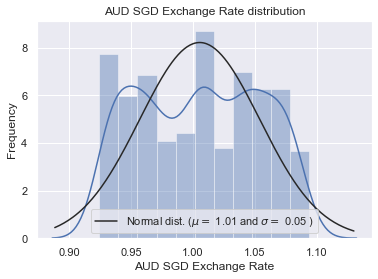

Skewness: -0.009726
Kurtosis: -1.256877


In [119]:
sns.distplot(df.sgd_exchange_rate_t_minus_6, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.sgd_exchange_rate_t_minus_6)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('AUD SGD Exchange Rate')
plt.title('AUD SGD Exchange Rate distribution')

fig = plt.figure()
res = stats.probplot(df.sgd_exchange_rate_t_minus_6, plot=plt)
plt.show()

print("Skewness: %f" % df.sgd_exchange_rate_t_minus_6.skew())
print("Kurtosis: %f" % df.sgd_exchange_rate_t_minus_6.kurt())

### Feature engineering

In [120]:
# df = pd.get_dummies(data=df, drop_first=True)

In [121]:
# these features slightly decrease the accuracy
# del df['sgd_exchange_rate_t_minus_6']
del df['usd_exchange_rate']
del df['volume_in_ml']
del df['national_avg_price']
del df['wholesale_cluster_label']
del df['tapis_oil_cluster_label']
# del df['price']
# df = df[['price','price_t_plus_1']]

In [122]:
df

price  tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01   1417                        5863                       1.0425   
2017-01-02   1436                        5863                       1.0425   
2017-01-03   1409                        5863                       1.0425   
2017-01-04   1542                        5863                       1.0425   
2017-01-05   1582                        5863                       1.0425   
...           ...                         ...                          ...   
2019-12-27   1608                        7084                       0.9386   
2019-12-28   1589                        7103                       0.9386   
2019-12-29   1579                        7159                       0.9386   
2019-12-30   1602                        7198                       0.9382   
2019-12-31   1609                        7177                       0.9377   

            wholesale_price_t_minus_4  price_t_plus_1  
2017-01-01                       1183            1436  
2017-01-02                       1183            1409  
2017-01-03                       1183            1542  
2017-01-04                       1183            1582  
2017-01-05                       1183            1529  
...                               ...             ...  
2019-12-27                       1332            1589  
2019-12-28                       1332            1579  
2019-12-29                       1335            1602  
2019-12-30                       1336            1609  
2019-12-31                       1338            1609  

[1095 rows x 5 columns]

### Prepare train and test data

In [123]:
y = df.price_t_plus_1
del df['price_t_plus_1']

In [124]:
# tscv = TimeSeriesSplit(n_splits=2)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state, shuffle=False)

In [125]:
# for train_index, test_index in tscv.split(df):
#     X_train, X_test = df.iloc[train_index], df.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     break

In [126]:
# X_test['2019-05-28':]
X_test.iloc[112]

price                          1718.0000
tapis_oil_price_t_minus_10     6512.0000
sgd_exchange_rate_t_minus_6       0.9468
wholesale_price_t_minus_4      1285.0000
Name: 2019-09-16 00:00:00, dtype: float64

In [127]:
# y_test['2019-05-28':]
y_test.iloc[112]

1696

### Scale data

In [128]:
# Scale X
should_scale = False

if should_scale:
#     ct = make_column_transformer((StandardScaler(), non_categorical_features))
#     ct = make_column_transformer((MinMaxScaler(feature_range=(-1,1)), non_categorical_features))
    ct = make_column_transformer((PowerTransformer(), non_categorical_features))
    
    result = ct.fit_transform(X_train)
    df_temp = pd.DataFrame(result, columns=non_categorical_features, index=X_train.index)

    for column in non_categorical_features:
        del X_train[column]

    X_train = X_train.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')

    result = ct.transform(X_test)
    df_temp = pd.DataFrame(result, columns=non_categorical_features, index=X_test.index)

    for column in non_categorical_features:
        del X_test[column]

    X_test = X_test.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')

In [129]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

### Predict price for next day

In [130]:
# y_train.shape
# df.info()
error_tolerance_percentage = 2.5

# estimators = [('ridge', RidgeCV()), ('lasso', LassoCV(random_state=random_state)), ('svr', SVR())] #84
# estimators = [('ridge', RidgeCV()), ('lars', LarsCV()), ('lassolars', LassoLarsCV()), 
#               ('omp', OrthogonalMatchingPursuitCV())]

est = linear_model.LinearRegression(normalize=False) # 89, 43 for 5 days ahead
# est = LarsCV(verbose=True).fit(X_train, y_train) # 88
# est = LassoCV(random_state=random_state).fit(X_train, y_train) #87
# est = LassoLarsCV().fit(X_train, y_train) #88
# est = ElasticNetCV(random_state=random_state).fit(X_train, y_train) #86
# est = OrthogonalMatchingPursuitCV().fit(X_train, y_train) # 88
# est = RidgeCV(normalize=False).fit(X_train, y_train) # 88
# est = Ridge(random_state=random_state).fit(X_train, y_train)
# est = PassiveAggressiveRegressor(random_state=random_state).fit(X_train, y_train) #87
# est = KNeighborsRegressor().fit(X_train, y_train) # 80
# est = GaussianProcessRegressor(random_state=random_state).fit(X_train, y_train) # -1
# est = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train) # 76
# est = BaggingRegressor(base_estimator=SVR(), random_state=random_state).fit(X_train, y_train) # 31
# est = AdaBoostRegressor(random_state=random_state).fit(X_train, y_train) # 70
# est = MLPRegressor(random_state=random_state, max_iter=10_000).fit(X_train, y_train) # 88, 87 on scaled data
# est = MLPRegressor(random_state=random_state, hidden_layer_sizes=(50, 50),
#                    learning_rate_init=0.01,
#               early_stopping=True).fit(X_train, y_train) # 88, 87 on scaled data

# est = StackingRegressor(estimators=estimators, # 89
#                         final_estimator=GradientBoostingRegressor(random_state=random_state)) 
#                         final_estimator=MLPRegressor(random_state=random_state, max_iter=10_000)) \
# est.fit(X_train, y_train)

# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = linear_model.LinearRegression()
# est = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)]).fit(X_train, y_train) # 83
# est = VotingRegressor(estimators=estimators).fit(X_train, y_train) # 89

In [131]:
est.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [132]:
# parameters = dict(alpha=(0.1,0.01))
# clf = Ridge(random_state=random_state)
# est = GridSearchCV(clf, parameters, verbose=1, cv=2).fit(X_train, y_train)

In [133]:
# est.cv_results_

In [134]:
# est.best_params_

In [135]:
est.score(X_test, y_test)

0.8925310736274185

In [136]:
y_hat = np.rint(est.predict(X_test))
get_relative_accuracy(y_test.values, y_hat, error_tolerance_percentage)

0.8538812785388128

In [137]:
mean_squared_error(y_test, y_hat)

939.4611872146119

In [138]:
mean_absolute_error(y_test, y_hat)

23.30593607305936

In [139]:
line_x_y = [math.floor(min(y_test.min(),y_hat.min())), math.ceil(max(y_test.max(),y_hat.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()

In [140]:
y_hat[112]

1705.0